In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers
from tensorflow.keras import regularizers
import keras_tuner as kt

from sklearn.metrics import mean_absolute_error, mean_squared_error


tf.__version__

2023-04-15 10:01:33.197902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 10:01:33.438977: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 10:01:34.385869: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-15 10:01:34.385928: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

'2.11.0'

In [30]:
# Load dataset
csv_file = '../Dataset/dataset_left_R1.csv'
dataframe_raw = pd.read_csv(csv_file)
dataframe_raw = dataframe_raw.drop(dataframe_raw.columns[0],axis=1) # remove first column (no information there)
dataframe_raw.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,Nsubs,R1,lambd
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,2,-0.3459,350.23
1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,2,-0.7931,347.50
2,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,4,-9.0919,364.11
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,27.8157,347.10
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,4,9.9743,358.78


In [31]:
dataframe = dataframe_raw.copy()

# Create a target variable
dataframe['target'] = dataframe['R1']

# Create array with number of subtitutes
nsubs = []
nsubs[:] = dataframe['Nsubs']

# Drop unused features.
dataframe = dataframe.drop(columns=['R1', 'lambd', 'Nsubs'])
dataframe.head()

,Pos1,Pos2,Pos3,Pos4,Pos5,Pos6,Pos7,Pos8,Pos9,Pos10,Pos11,Pos12,Pos13,Pos14,Pos15,Pos16,target
0,0,0,0,0,0,4,1,0,0,0,0,0,0,0,0,0,-0.3459
1,0,4,2,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.7931
2,3,3,0,0,0,0,0,1,2,0,0,0,0,0,0,0,-9.0919
3,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27.8157
4,0,1,0,0,4,0,0,0,0,4,0,3,0,0,0,0,9.9743


1
32
140
40
40


(array([  1.,  32., 140.,  40.,  40.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5]),
 <BarContainer object of 5 artists>)

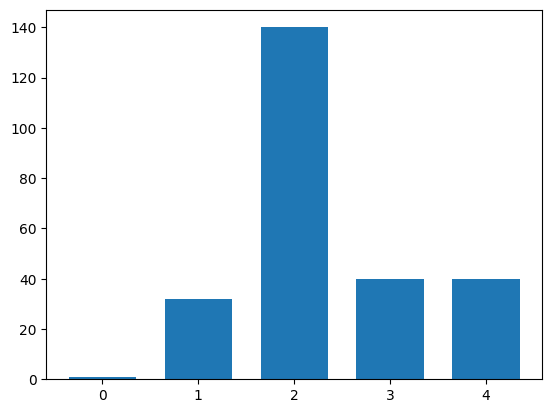

In [32]:
# number of substitutes

n0 = nsubs.count(0)
n1 = nsubs.count(1)
n2 = nsubs.count(2)
n3 = nsubs.count(3)
n4 = nsubs.count(4)
print(n0)
print(n1)
print(n2)
print(n3)
print(n4)

bin_edges = np.arange(-0.5,4.5+1,1)
plt.hist(nsubs, bins=bin_edges, rwidth=0.7)

In [33]:
# Check overal statistis of each input feature 
dataframe.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,253.0,0.664032,1.251099,0.0000,0.000,0.0000,1.0000,4.0000
Pos2,253.0,0.774704,1.388956,0.0000,0.000,0.0000,1.0000,4.0000
Pos3,253.0,0.632411,1.258013,0.0000,0.000,0.0000,0.0000,4.0000
Pos4,253.0,0.557312,1.218930,0.0000,0.000,0.0000,0.0000,4.0000
Pos5,253.0,0.513834,1.121934,0.0000,0.000,0.0000,0.0000,4.0000
Pos6,253.0,0.430830,1.054167,0.0000,0.000,0.0000,0.0000,4.0000
Pos7,253.0,0.383399,1.007532,0.0000,0.000,0.0000,0.0000,4.0000
Pos8,253.0,0.533597,1.163200,0.0000,0.000,0.0000,0.0000,4.0000
Pos9,253.0,0.332016,0.904378,0.0000,0.000,0.0000,0.0000,4.0000
Pos10,253.0,0.284585,0.867193,0.0000,0.000,0.0000,0.0000,4.0000


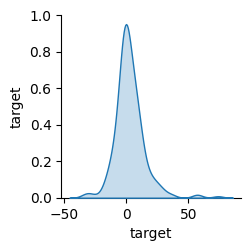

In [34]:
# Inspect the data with the joint distribition of a few pairs of columns from the training set
sns.pairplot(dataframe[['target']], diag_kind='kde')


In [35]:
""" # remove data with R~8

dataframe = dataframe[ dataframe['target']>10 ]
dataframe.describe().transpose() """

# remove data with target>Rmax
Rmax = 50
dataframe = dataframe[ dataframe['target']<Rmax ]
print(dataframe.describe().transpose())

        count      mean        std      min      25%      50%       75%  \
Pos1    250.0  0.640000   1.221626   0.0000  0.00000  0.00000  1.000000   
Pos2    250.0  0.768000   1.380507   0.0000  0.00000  0.00000  1.000000   
Pos3    250.0  0.640000   1.263640   0.0000  0.00000  0.00000  0.000000   
Pos4    250.0  0.548000   1.205616   0.0000  0.00000  0.00000  0.000000   
Pos5    250.0  0.508000   1.116657   0.0000  0.00000  0.00000  0.000000   
Pos6    250.0  0.436000   1.059431   0.0000  0.00000  0.00000  0.000000   
Pos7    250.0  0.388000   1.012698   0.0000  0.00000  0.00000  0.000000   
Pos8    250.0  0.540000   1.168702   0.0000  0.00000  0.00000  0.000000   
Pos9    250.0  0.336000   0.909071   0.0000  0.00000  0.00000  0.000000   
Pos10   250.0  0.272000   0.839545   0.0000  0.00000  0.00000  0.000000   
Pos11   250.0  0.212000   0.738402   0.0000  0.00000  0.00000  0.000000   
Pos12   250.0  0.248000   0.832628   0.0000  0.00000  0.00000  0.000000   
Pos13   250.0  0.108000  

In [36]:
# normalize numerical targets

R_mean = dataframe['target'].mean()
R_std = dataframe['target'].std()

dataset = dataframe.copy()

dataset['target']=(dataset['target']-R_mean)/R_std

# Check overal statistis of each input feature 
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pos1,250.0,6.400000e-01,1.221626,0.000000,0.000000,0.000000,1.000000,4.000000
Pos2,250.0,7.680000e-01,1.380507,0.000000,0.000000,0.000000,1.000000,4.000000
Pos3,250.0,6.400000e-01,1.263640,0.000000,0.000000,0.000000,0.000000,4.000000
Pos4,250.0,5.480000e-01,1.205616,0.000000,0.000000,0.000000,0.000000,4.000000
Pos5,250.0,5.080000e-01,1.116657,0.000000,0.000000,0.000000,0.000000,4.000000
Pos6,250.0,4.360000e-01,1.059431,0.000000,0.000000,0.000000,0.000000,4.000000
Pos7,250.0,3.880000e-01,1.012698,0.000000,0.000000,0.000000,0.000000,4.000000
Pos8,250.0,5.400000e-01,1.168702,0.000000,0.000000,0.000000,0.000000,4.000000
Pos9,250.0,3.360000e-01,0.909071,0.000000,0.000000,0.000000,0.000000,4.000000
Pos10,250.0,2.720000e-01,0.839545,0.000000,0.000000,0.000000,0.000000,4.000000


In [37]:
# Shuffle the dataset
dataset = dataset.sample(frac=1,random_state=42).reset_index(drop=True)
#dataset = dataset.sample(frac=0.5,random_state=42).reset_index(drop=True)

# Split the dataframe into training, validation, and test sets
train_ds = dataset.sample(frac=0.8, random_state=10)
test_ds = dataset.drop(train_ds.index)
print(len(train_ds), 'training examples')
print(len(test_ds), 'test and validation examples')

# split features and labels/targets
train_features = train_ds.copy()
test_features = test_ds.copy()

train_labels = train_features.pop('target')
test_labels = test_features.pop('target')
print(train_features.shape)
print(train_labels.shape)


200 training examples
50 test and validation examples
(200, 16)
(200,)


In [ ]:
# Create the model architecture

""" n_features = train_features.shape[1]
input = tf.keras.Input(shape=(n_features,))
model = tf.keras.Sequential()
model.add(input) """

# tiny model
#x = tf.keras.layers.Dense(8, activation="relu")(all_features)

# small model 
#x = tf.keras.layers.Dense(16, activation="relu")(all_features)
#x = tf.keras.layers.Dense(16, activation="relu")(x)

# medium model
""" model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu"))
model.add(tf.keras.layers.Dense(64, activation="relu")) """

# large model
#x = tf.keras.layers.Dense(512, activation="relu")(all_features)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(512, activation="relu")(x)

# large model with L2-regularization and dropout
""" x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001), activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x) """

""" #x = tf.keras.layers.Dense(10)(x)
#output = tf.keras.layers.Dense(1)(x)
model.add(tf.keras.layers.Dense(1))

#model = tf.keras.Model(all_inputs, output)
model.summary()

#loss='mean_absolute_error',optimizer=tf.keras.optimizers.Adam(0.001)
# compile the model
model.compile(#optimizer='adam',
              #loss='mean_absolute_error',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              loss=tf.keras.losses.MeanAbsoluteError(),
              optimizer=tf.keras.optimizers.Adam(0.0001)
              #optimizer=tf.keras.optimizers.Adam(0.001),
              #metrics=["accuracy"])
)

tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR") """

In [38]:
# Define the hypermodel to optimize hyperparameters

def model_builder(hp):
  
  n_features = train_features.shape[1]
  input = tf.keras.Input(shape=(n_features,))
  model = tf.keras.Sequential()
  model.add(input)

  # Tune the number of units in the Dense layers
  # Choose an optimal value between 8-128
  hp_units = hp.Int('units', min_value=8, max_value=128, step=2, sampling='log')
  
  # Tune the number of layers between 1-4
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1)
  #hp_layers = hp.Int('layers', min_value=1, max_value=4, step=1, sampling='linear')
  hp_layers = hp.Int('layers', min_value=1, max_value=4, step=2, sampling='log')

  # Tune activation function between relu, tanh and sigmoid
  #hp_activation = hp.Choice('activation', values=['relu','tanh','sigmoid'])
  hp_activation = hp.Choice('activation', values=['relu','tanh'])

  # Define architecture
  for i in range(hp_layers):
    #model.add(keras.layers.Dense(units=hp_units, activation='tanh'))
    model.add(tf.keras.layers.Dense(units=hp_units, activation=hp_activation))
  model.add(tf.keras.layers.Dense(1))

  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  # Tune the batch size
  #hp_batch = hp.Int('batch', min_value=32, max_value=256, step=2, sampling='log')

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='mean_absolute_error')   

  return model

In [39]:
# Instantiate the tuner and perform hypertuning

tuner = kt.Hyperband(model_builder,
                     #objective='val_accuracy',
                     objective='val_loss',
                     #max_epochs=10,
                     max_epochs=100,
                     factor=3,
                     #factor=2,
                     directory='./Hypertuning',
                     project_name='hypertuning_left_IntEnc_explore_R1')

INFO:tensorflow:Reloading Tuner from ./Hypertuning/hypertuning_left_IntEnc_explore_R1/tuner0.json


In [40]:
# Create a callback to stop training early after reaching a certain value for the validation loss.
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# search() method receives same arguments as fit() method, plus callbacks
# if batch_size is not specified, 32 is the default value
batch_size = 4
tuner.search(train_features, train_labels, epochs=100, validation_split=0.1, batch_size=batch_size, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: {best_hps.get('layers')}
n_units: {best_hps.get('units')}
learning_rate: {best_hps.get('learning_rate')}
activation_function: {best_hps.get('activation')}
""")

INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete! The optimal number of layers, number of units, 
learning rate and activation function are:
n_layers: 1
n_units: 16
learning_rate: 0.01
activation_function: relu



In [41]:
# Train the model with optimal hyperparameters

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=10, min_lr=1e-6)

# Build the model with the optimal hyperparameters and train it on the data for 500 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_features, train_labels, epochs=150, batch_size=batch_size
, validation_split=0.1, callbacks=[reduce_lr], verbose=2)

Epoch 1/150
45/45 - 1s - loss: 0.6495 - val_loss: 0.6433 - lr: 0.0100 - 544ms/epoch - 12ms/step
Epoch 2/150
45/45 - 0s - loss: 0.5164 - val_loss: 0.5272 - lr: 0.0100 - 45ms/epoch - 992us/step
Epoch 3/150
45/45 - 0s - loss: 0.4738 - val_loss: 0.5937 - lr: 0.0100 - 45ms/epoch - 1ms/step
Epoch 4/150
45/45 - 0s - loss: 0.4646 - val_loss: 0.5137 - lr: 0.0100 - 43ms/epoch - 951us/step
Epoch 5/150
45/45 - 0s - loss: 0.4527 - val_loss: 0.5593 - lr: 0.0100 - 43ms/epoch - 962us/step
Epoch 6/150
45/45 - 0s - loss: 0.4284 - val_loss: 0.5184 - lr: 0.0100 - 43ms/epoch - 966us/step
Epoch 7/150
45/45 - 0s - loss: 0.3904 - val_loss: 0.4961 - lr: 0.0100 - 46ms/epoch - 1ms/step
Epoch 8/150
45/45 - 0s - loss: 0.3782 - val_loss: 0.5153 - lr: 0.0100 - 43ms/epoch - 965us/step
Epoch 9/150
45/45 - 0s - loss: 0.3664 - val_loss: 0.5535 - lr: 0.0100 - 45ms/epoch - 999us/step
Epoch 10/150
45/45 - 0s - loss: 0.4134 - val_loss: 0.5832 - lr: 0.0100 - 39ms/epoch - 877us/step
Epoch 11/150
45/45 - 0s - loss: 0.3858 - va

Best epoch: 139


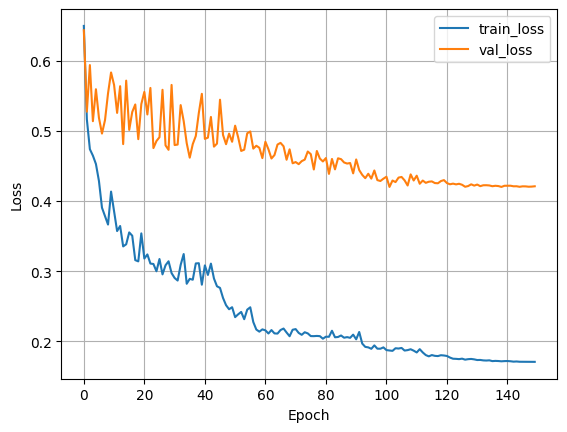

In [42]:
# Plot the loss

plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
#plt.ylim([0, 10])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

val_loss_per_epoch = history.history['val_loss']
train_loss_per_epoch = history.history['loss']
best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
""" # Re-instantiate the hypermodel and train it with the optimal number of epochs from above.

best_model = tuner.hypermodel.build(best_hps)

# Retrain the model
best_model.fit(train_features, train_labels, epochs=best_epoch, batch_size=batch_size, validation_split=0.1,callbacks=[reduce_lr], verbose=2) """

In [43]:
def plot_PredvsTrue(y_true, y_pred):

    plt.figure(figsize=(3, 3), dpi=200)
    p1 = min(y_true)
    p2 = max(y_true)
    #p1 = 0
    #p2 = 64
    #p1 = max(max(y_pred), max(y_true))
    #p2 = min(min(y_pred), min(y_true))
    plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
    plt.scatter(y_true,y_pred,color="blue",label="Model",s=6)
    plt.xlabel('True',fontsize=15)
    plt.ylabel('Pred',fontsize=15)
    plt.legend(loc="upper left")
    plt.show()

2/2 [==============================] - 0s 3ms/step
(50, 1)
(50, 1)


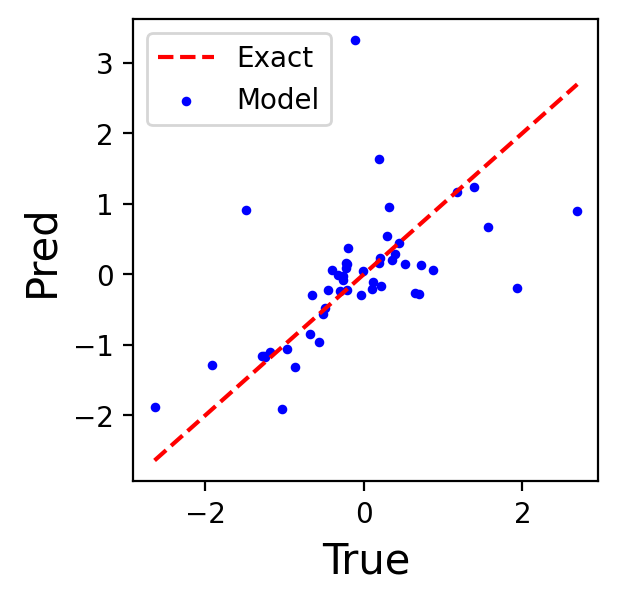

Test MAE: 0.513668052472143


In [44]:
# Pred vs True values on test set 

y_pred = model.predict(test_features)
y_pred.shape
y_true = np.zeros((len(test_ds['target']),1))
y_true[:,0] = test_ds['target']

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Test MAE: "+str(test_mae))

In [ ]:
""" # Pred vs True values on training set 

y_pred = model.predict(train_features)
y_pred.shape
y_true = np.zeros((len(train_ds['target']),1))
y_true[:,0] = train_ds['target']

print(y_true.shape)
print(y_pred.shape)
#print(y_true)
#print(y_pred)

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE: "+str(test_mae)) """

In [ ]:
""" # Evaluate the model with non-normalized units

y_true = y_true * R_std + R_mean
y_pred = y_pred * R_std + R_mean

#print("True: "+str(y_true))
#print("Pred: "+str(y_pred))

plot_PredvsTrue(y_true, y_pred)

test_mae = mean_absolute_error(y_true,y_pred)
print("Train MAE (non-normalized): "+str(test_mae)) """

In [139]:
# save model

#model.save('R_model_good_tiny')
#model.save('R_model_good_small')
#model.save('R_model_good_medium')
#model.save('R_model_good_large')
#reloaded_model = tf.keras.models.load_model('R_model')

7/7 [==============================] - 0s 1ms/step


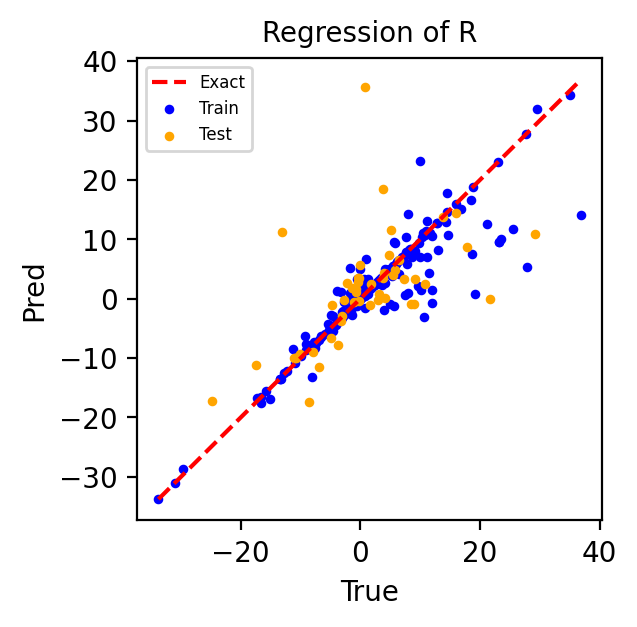

train MAE (non-normalized): 1.9834376910743714
test MAE (non-normalized): 5.217793411342622


In [45]:
# Evaluate the model with non-normalized units on the whole dataset

y_pred_test = model.predict(test_features)
y_true_test = np.zeros((len(test_ds['target']),1))
y_true_test[:,0] = test_ds['target']

y_pred_train = model.predict(train_features)
y_true_train = np.zeros((len(train_ds['target']),1))
y_true_train[:,0] = train_ds['target']

#y_pred_val = model.predict(val_ds)
#y_true_val = np.zeros((len(val['target']),1))
#y_true_val[:,0] = val['target']

y_true_test = y_true_test * R_std + R_mean
y_pred_test = y_pred_test * R_std + R_mean
y_true_test = y_true_test.ravel()
y_pred_test = y_pred_test.ravel()

y_true_train = y_true_train * R_std + R_mean
y_pred_train = y_pred_train * R_std + R_mean
y_true_train = y_true_train.ravel()
y_pred_train = y_pred_train.ravel()

#y_true_val = y_true_val * R_std + R_mean
#y_pred_val = y_pred_val * R_std + R_mean
#y_true_val = y_true_val.ravel()
#y_pred_val = y_pred_val.ravel()

plt.figure(figsize=(3, 3), dpi=200)
plt.title("Regression of R",fontsize=10)
p1 = min(y_true_train)
p2 = max(y_true_train)
plt.plot([p1, p2], [p1, p2], 'r--', label="Exact")
plt.scatter(y_true_train,y_pred_train,color="blue",label="Train",s=6)
plt.scatter(y_true_test,y_pred_test,color="orange",label="Test",s=6)
#plt.scatter(y_true_val,y_pred_val,color="green",label="Val",s=6)
plt.xlabel('True',fontsize=10)
plt.ylabel('Pred',fontsize=10)
plt.legend(loc="upper left",prop={'size': 6})
plt.show()

train_mae = mean_absolute_error(y_true_train,y_pred_train)
print("train MAE (non-normalized): "+str(train_mae))
test_mae = mean_absolute_error(y_true_test,y_pred_test)
print("test MAE (non-normalized): "+str(test_mae))
#val_mae = mean_absolute_error(y_true_val,y_pred_val)
#print("val MAE (non-normalized): "+str(val_mae))

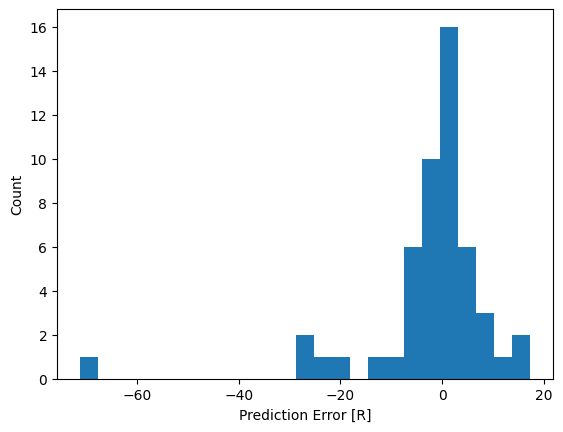

In [20]:
# Error distribution
error = y_pred_test - y_true_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')


[ 0.  5. 24. 14.  8.]
[        nan  5.63169718  4.13556496  9.16918676 14.25549452]


/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/alfonso/Work/UGR/Calculations/Helicenes_NNs/Helicenes_venv/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


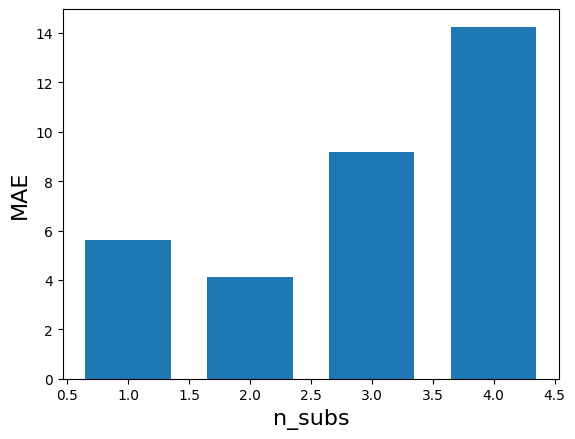

In [21]:
# Error for different nsubs

x_test = test_features.to_numpy()

nsubs_test = np.zeros( x_test.shape[0] )
nsubs_test = np.count_nonzero( x_test,axis=1 )
#print(x_test[0,:])
#print(nsubs_test)

nmax = 100
error0 = []
error1 = []
error2 = []
error3 = []
error4 = []
num_subs = np.zeros(5)
for i in range(len(nsubs_test)):
    error_i = y_pred_test[i] - y_true_test[i]
    if(nsubs_test[i]==0): 
        error0.append(error_i)
        num_subs[0] +=1
    if(nsubs_test[i]==1): 
        error1.append(error_i)
        num_subs[1] +=1
    if(nsubs_test[i]==2): 
        error2.append(error_i)
        num_subs[2] +=1
    if(nsubs_test[i]==3): 
        error3.append(error_i)
        num_subs[3] +=1
    if(nsubs_test[i]==4): 
        error4.append(error_i)
        num_subs[4] +=1

""" nbins = 50    
plt.hist(error0, bins=nbins, label='nsubs=0')
plt.hist(error1, bins=nbins, label='nsubs=1')
plt.hist(error2, bins=nbins, label='nsubs=2')
plt.hist(error3, bins=nbins, label='nsubs=3')
plt.hist(error4, bins=nbins, label='nsubs=4')
plt.legend()
plt.xlabel('Prediction Error [R]')
_ = plt.ylabel('Count')
plt.show() """

error_nsubs = np.zeros(5)
error_nsubs[0] = np.mean(np.abs(error0))
error_nsubs[1] = np.mean(np.abs(error1))
error_nsubs[2] = np.mean(np.abs(error2))
error_nsubs[3] = np.mean(np.abs(error3))
error_nsubs[4] = np.mean(np.abs(error4))

print(num_subs)
print(error_nsubs)

bin_edges = np.arange(1.5,4.5+1,1)
plt.bar([0,1,2,3,4],error_nsubs[0:], width=0.7)
plt.xlabel("n_subs",fontsize=16)
plt.ylabel("MAE",fontsize=16)
plt.show()
